The below code is an implementation for TD7, using self-supervised learning technique-SALE.We make representations/emebeddings for State and State Action and concatenate them.
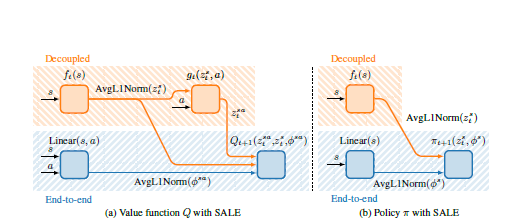

The objective of SALE is to discover learned embeddings (zsa, zs) which capture relevant structure
in the observation space, as well as the transition dynamics of the environment. To do so, SALE
utilizes a pair of encoders (f, g) where f(s) encodes the state s into the state embedding zs and
g(zs, a) jointly encodes both state s and action a into the state-action embedding zsa

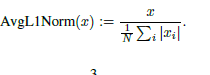

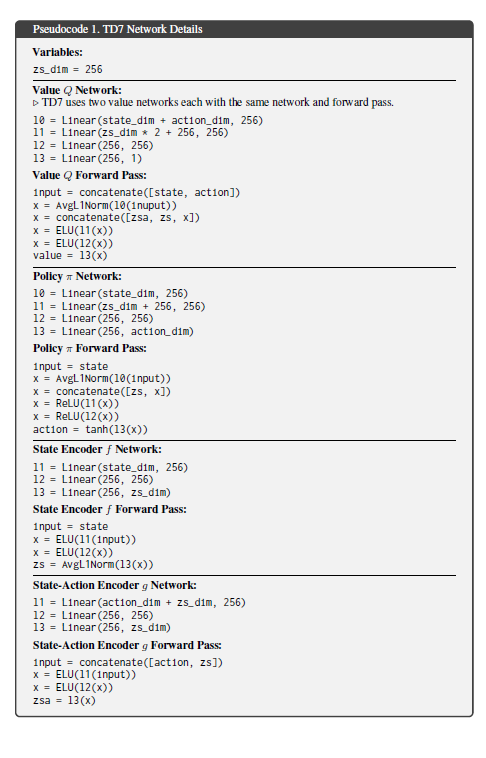

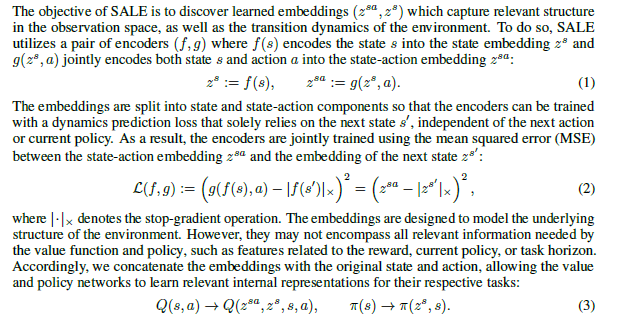

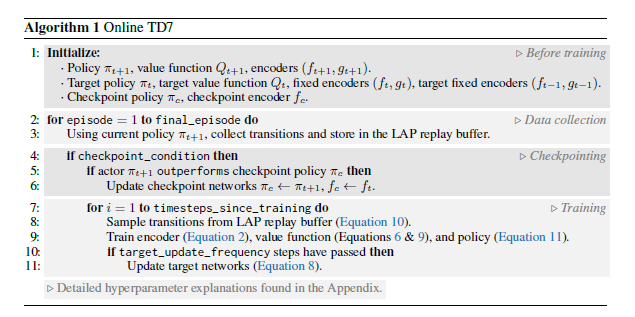

TD7 is based on TD3 [Fujimoto et al., 2018] with LAP [Fujimoto et al., 2020], a behavior cloning term
for offline RL [Fujimoto and Gu, 2021], SALE (Section 4.1), and policy checkpoints

In [1]:
pip install mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 72.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 14.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


state_dim:  11 , action_dim:  3
max_action:  1.0 , threshold:  3800.0 , std_noise:  0.02
Low in action space:  [-1. -1. -1.] , High:  [1. 1. 1.] , Action_dim:  3
Ep. 10, Timestep 195,  Ep.Timesteps 23, Score: 14.23, Avg.Score: 14.91, Max.Score: 27.12, Time: 00:00:01 
Ep. 20, Timestep 466,  Ep.Timesteps 14, Score: 10.41, Avg.Score: 18.23, Max.Score: 63.69, Time: 00:00:05 
Ep. 30, Timestep 692,  Ep.Timesteps 34, Score: 17.41, Avg.Score: 17.69, Max.Score: 63.69, Time: 00:00:07 
Ep. 40, Timestep 889,  Ep.Timesteps 34, Score: 15.56, Avg.Score: 16.70, Max.Score: 63.69, Time: 00:00:10 
Ep. 50, Timestep 1047,  Ep.Timesteps 8, Score: 5.65, Avg.Score: 16.07, Max.Score: 63.69, Time: 00:00:12 
Ep. 60, Timestep 1237,  Ep.Timesteps 18, Score: 15.48, Avg.Score: 15.48, Max.Score: 63.69, Time: 00:00:15 
Ep. 70, Timestep 1434,  Ep.Timesteps 24, Score: 18.68, Avg.Score: 15.58, Max.Score: 63.69, Time: 00:00:17 
Ep. 80, Timestep 1687,  Ep.Timesteps 18, Score: 9.88, Avg.Score: 15.71, Max.Score: 63.69, Time:

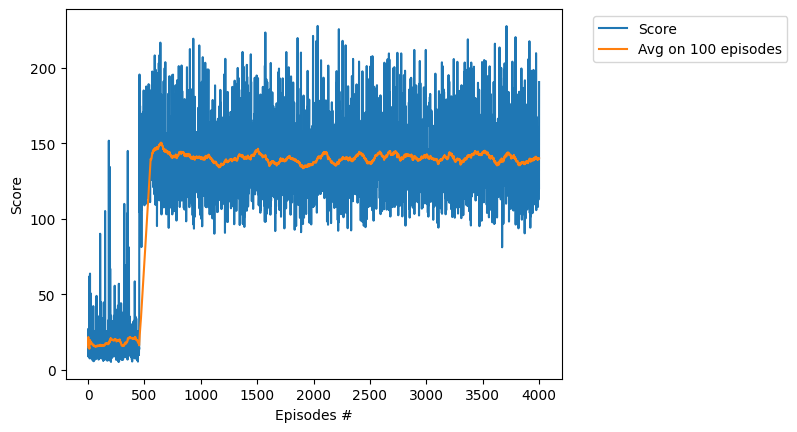

Episode 1	Average Score: 139.52,	Score: 139.52 	Time: 00:00:01
Episode 2	Average Score: 144.11,	Score: 148.70 	Time: 00:00:01
Episode 3	Average Score: 141.81,	Score: 137.21 	Time: 00:00:01
Episode 4	Average Score: 144.80,	Score: 153.78 	Time: 00:00:01
Episode 5	Average Score: 144.59,	Score: 143.74 	Time: 00:00:01
Episode 6	Average Score: 141.95,	Score: 128.73 	Time: 00:00:00
Episode 7	Average Score: 140.40,	Score: 131.14 	Time: 00:00:01


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import time
import matplotlib.pyplot as plt
import gymnasium as gym
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class StateEncoder(nn.Module):
    def __init__(self, state_dim, zs_dim=256):
        super(StateEncoder, self).__init__()
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, zs_dim)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        zs = self.l3(x)
        return zs

class StateActionEncoder(nn.Module):
    def __init__(self, action_dim, zs_dim=256, zsa_dim=256):
        super(StateActionEncoder, self).__init__()
        self.l1 = nn.Linear(action_dim + zs_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, zsa_dim)

    def forward(self, action, zs):
        x = torch.cat([action, zs], dim=1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        zsa = self.l3(x)
        return zsa

class ValueNetwork(nn.Module):
    def __init__(self, zs_dim=256):
        super(ValueNetwork, self).__init__()
        # Value networks (Q-networks)
        self.l1 = nn.Linear(zs_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

    def forward(self, zs):
        x = F.relu(self.l1(zs))
        x = F.relu(self.l2(x))
        value = self.l3(x)
        return value

class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Policy, self).__init__()
        # Policy network (Actor)
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        action = torch.tanh(self.l3(x)) * self.max_action
        return action

class PrioritizedReplayBuffer:
    def __init__(self, max_size=1e6, alpha=0.6):
        self.max_size = int(max_size)
        self.alpha = alpha
        self.buffer = deque(maxlen=self.max_size)
        self.priorities = deque(maxlen=self.max_size)

    def add(self, data, priority=1.0):
        self.buffer.append(data)
        self.priorities.append(float(priority) ** self.alpha)  # Ensure priority is a float

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        batch = [self.buffer[idx] for idx in indices]

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()

        states, next_states, actions, rewards, dones = zip(*batch)
        return (np.array(states), np.array(next_states), np.array(actions),
                np.array(rewards).reshape(-1, 1), np.array(dones).reshape(-1, 1),
                indices, torch.tensor(weights, dtype=torch.float32).to(device))

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = float(priority.item()) ** self.alpha  # Convert array to scalar safely


class TD7:
    def __init__(self, state_dim, action_dim, max_action, n_step=3, gamma=0.99, zs_dim=256, zsa_dim=256):
        
        self.zs_dim = zs_dim
        self.zsa_dim = zsa_dim

        self.state_encoder = StateEncoder(state_dim, zs_dim).to(device)
        self.state_encoder_target = StateEncoder(state_dim, zs_dim).to(device)
        self.state_encoder_target.load_state_dict(self.state_encoder.state_dict())

        # State-action encoder
        self.state_action_encoder = StateActionEncoder(action_dim, zs_dim, zsa_dim).to(device)
        self.state_action_encoder_target = StateActionEncoder(action_dim, zs_dim, zsa_dim).to(device)
        self.state_action_encoder_target.load_state_dict(self.state_action_encoder.state_dict())

       
        self.policy = Policy(state_dim, action_dim, max_action).to(device)
        self.policy_target = Policy(state_dim, action_dim, max_action).to(device)
        self.policy_target.load_state_dict(self.policy.state_dict())

        # Create multiple value networks (3 in total as per diagram)
        self.value_networks = [ValueNetwork(zs_dim).to(device) for _ in range(3)]
        self.value_networks_target = [ValueNetwork(zs_dim).to(device) for _ in range(3)]

        for i in range(len(self.value_networks)):
            self.value_networks_target[i].load_state_dict(self.value_networks[i].state_dict())

        # Optimizers
        self.state_encoder_optimizer = torch.optim.Adam(self.state_encoder.parameters())
        self.state_action_encoder_optimizer = torch.optim.Adam(self.state_action_encoder.parameters())
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters())
        self.value_optimizers = [torch.optim.Adam(network.parameters()) for network in self.value_networks]

        self.device = device
        self.max_action = max_action
        self.n_step = n_step
        self.gamma = gamma

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=100, tau=0.005):
        for it in range(iterations):
            # Sample from replay buffer
            states, next_states, actions, rewards, dones, indices, weights = replay_buffer.sample(batch_size)

            state = torch.FloatTensor(states).to(device)
            action = torch.FloatTensor(actions).to(device)
            next_state = torch.FloatTensor(next_states).to(device)
            reward = torch.FloatTensor(rewards).to(device)
            done = torch.FloatTensor(1 - dones).to(device)

            # Get state encodings
            zs = self.state_encoder(state)
            zs_target = self.state_encoder_target(next_state)

            # Get state-action encodings
            zsa = self.state_action_encoder(action, zs)

            # Get next actions from target policy
            next_action = self.policy_target(next_state)

            # Get target Q-values from all three value networks
            target_values = [value_net(zs_target) for value_net in self.value_networks_target]

            # Take the minimum of the target values
            target_value = torch.min(torch.cat(target_values, dim=1), dim=1, keepdim=True)[0]

            # Calculate target value with n-step return
            n_step_discount = self.gamma ** self.n_step
            target_value = reward + (done * n_step_discount * target_value).detach()

            # Update all three value networks
            value_losses = []
            for i, value_net in enumerate(self.value_networks):
                current_value = value_net(zs)
                value_loss = F.mse_loss(current_value, target_value)

                self.value_optimizers[i].zero_grad()
                value_loss.backward(retain_graph=True if i < len(self.value_networks)-1 else False)
                self.value_optimizers[i].step()

                value_losses.append(value_loss.item())

            # Update priorities in replay buffer based on TD error
            td_errors = torch.abs(self.value_networks[0](zs) - target_value)
            replay_buffer.update_priorities(indices, td_errors)

            # Delayed policy updates
            if it % 2 == 0:
                # Update policy by maximizing the first value network
                zs_policy = self.state_encoder(state)
                policy_action = self.policy(state)
                zsa_policy = self.state_action_encoder(policy_action, zs_policy)

                # Actor loss - maximize Q-value for policy actions
                actor_loss = -self.value_networks[0](zs_policy).mean()

                self.policy_optimizer.zero_grad()
                actor_loss.backward()
                self.policy_optimizer.step()

                # Update target networks with Polyak averaging
                for param, target_param in zip(self.state_encoder.parameters(), self.state_encoder_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.state_action_encoder.parameters(), self.state_action_encoder_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.policy.parameters(), self.policy_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for i in range(len(self.value_networks)):
                    for param, target_param in zip(self.value_networks[i].parameters(), self.value_networks_target[i].parameters()):
                        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


def save(agent, filename, directory):
    # Save state encoder
    torch.save(agent.state_encoder.state_dict(), f'{directory}/{filename}_state_encoder.pth')
    torch.save(agent.state_encoder_target.state_dict(), f'{directory}/{filename}_state_encoder_target.pth')

    # Save state-action encoder
    torch.save(agent.state_action_encoder.state_dict(), f'{directory}/{filename}_state_action_encoder.pth')
    torch.save(agent.state_action_encoder_target.state_dict(), f'{directory}/{filename}_state_action_encoder_target.pth')

    # Save policy
    torch.save(agent.policy.state_dict(), f'{directory}/{filename}_policy.pth')
    torch.save(agent.policy_target.state_dict(), f'{directory}/{filename}_policy_target.pth')

    # Save value networks
    for i in range(len(agent.value_networks)):
        torch.save(agent.value_networks[i].state_dict(), f'{directory}/{filename}_value_{i}.pth')
        torch.save(agent.value_networks_target[i].state_dict(), f'{directory}/{filename}_value_{i}_target.pth')


def load(agent, filename, directory):
    # Load state encoder
    agent.state_encoder.load_state_dict(torch.load(f'{directory}/{filename}_state_encoder.pth'))
    agent.state_encoder_target.load_state_dict(torch.load(f'{directory}/{filename}_state_encoder_target.pth'))

    # Load state-action encoder
    agent.state_action_encoder.load_state_dict(torch.load(f'{directory}/{filename}_state_action_encoder.pth'))
    agent.state_action_encoder_target.load_state_dict(torch.load(f'{directory}/{filename}_state_action_encoder_target.pth'))

    # Load policy
    agent.policy.load_state_dict(torch.load(f'{directory}/{filename}_policy.pth'))
    agent.policy_target.load_state_dict(torch.load(f'{directory}/{filename}_policy_target.pth'))

    # Load value networks
    for i in range(len(agent.value_networks)):
        agent.value_networks[i].load_state_dict(torch.load(f'{directory}/{filename}_value_{i}.pth'))
        agent.value_networks_target[i].load_state_dict(torch.load(f'{directory}/{filename}_value_{i}_target.pth'))

    return agent


def twin_d7_train(env, agent, n_episodes=4000, save_every=10, print_env=10, start_timestep=1e4, std_noise=0.02):
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    time_start = time.time()                    # Init start time
    replay_buf = PrioritizedReplayBuffer()      # Init PrioritizedReplayBuffer

    timestep_after_last_save = 0
    total_timesteps = 0

    low = env.action_space.low
    high = env.action_space.high
    action_dim = env.action_space.shape[0]
    threshold = env.spec.reward_threshold

    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)

    for i_episode in range(1, n_episodes+1):
        timestep = 0
        total_reward = 0

        # Reset environment
        state = env.reset()[0]  # Updated to handle the new return format
        done = False

        while True:
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0:
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)

            # Perform action with updated handling of return values
            result = env.step(action)
            new_state, reward, terminated, truncated = result[0], result[1], result[2], result[3]
            done = terminated or truncated

            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        max_score = np.max(scores_deque)

        s = (int)(time.time() - time_start)
        if i_episode % print_env == 0 or (len(scores_deque) == 100 and avg_score > threshold):
            print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Max.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, max_score, s//3600, s%3600//60, s%60))

        # Only train if we have enough samples in the buffer
        if len(replay_buf.buffer) >= 100:  # Minimum batch size
            agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
        if timestep_after_last_save >= save_every and i_episode > 0:
            timestep_after_last_save %= save_every
            save(agent, 'chpnt_interm', 'dir_chk_002')

        if len(scores_deque) == 100 and avg_score >= threshold:
            print('Environment solved with Average Score: ',  avg_score )
            break

    return scores_array, avg_scores_array


def play(env, agent, n_episodes):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]  # Updated for new API
        score = 0

        time_start = time.time()

        while True:
            action = agent.select_action(np.array(state))

            time.sleep(0.01)

            # Updated for new API
            result = env.step(action)
            next_state, reward, terminated, truncated = result[0], result[1], result[2], result[3]
            done = terminated or truncated

            state = next_state
            score += reward
            if done:
                break

        s = (int)(time.time() - time_start)

        scores_deque.append(score)
        scores.append(score)

        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))


# Main execution code
if __name__ == "__main__":
    # Create directory for checkpoints if it doesn't exist
    if not os.path.exists('dir_chk_002'):
        os.makedirs('dir_chk_002')

    # Configuration parameters
    start_timestep = 1e4
    std_noise = 0.02

    # Create the environment
    env = gym.make("Hopper-v4")

    # Set seeds for reproducibility
    seed = 12345
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize state and get environment dimensions
    state = env.reset()[0]
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    threshold = env.spec.reward_threshold

    print('state_dim: ', state_dim, ', action_dim: ', action_dim)
    print('max_action: ', max_action, ', threshold: ', threshold, ', std_noise: ', std_noise)

    # Initialize TD7 agent
    agent = TD7(state_dim, action_dim, max_action)

    # Train the agent
    scores, avg_scores = twin_d7_train(env, agent, start_timestep=start_timestep, std_noise=std_noise)

    # Plot training results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
    plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylabel('Score')
    plt.xlabel('Episodes #')
    plt.show()

    # Test the trained agent
    play(env=env, agent=agent, n_episodes=7)

    # Close the environment
    env.close()